# Light FM

use items' and users' features 

In [1]:
!ls

01_explict_CF_intro.ipynb	04_lightFM.ipynb  ml-100k
02_explicit_ALS_SGD.ipynb	explict_CF.py	  README.md
03_implict_ALS_sketchlab.ipynb	helpers.py	  rec-a-sketch


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import scipy.sparse as sp
from scipy.special import expit ## ??
import pickle
import csv
import copy 
import itertools
from lightfm import LightFM
import lightfm.evaluation
import sys
import helpers
plt.style.use('ggplot')

In [3]:
df = pd.read_csv('rec-a-sketch/model_likes_anon.psv',
                sep='|', quoting=csv.QUOTE_MINIMAL,
                quotechar = '\\')
df.drop_duplicates(inplace=True)
df.head()

,modelname,mid,uid
0,3D fanart Noel From Sora no Method,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,7ac1b40648fff523d7220a5d07b04d9b
1,3D fanart Noel From Sora no Method,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,2b4ad286afe3369d39f1bb7aa2528bc7
2,3D fanart Noel From Sora no Method,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,1bf0993ebab175a896ac8003bed91b4b
3,3D fanart Noel From Sora no Method,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,6484211de8b9a023a7d9ab1641d22e7c
4,3D fanart Noel From Sora no Method,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,1109ee298494fbd192e27878432c718a


In [4]:
# Threshold data to only include users and models with min 5 likes
df = helpers.threshold_interactions_df(df,'uid','mid',5,5)

Starting interactions info
Number of rows: 62583
Number of cols: 28806
Sparsity: 0.035%
Ending interactions info
Number of rows: 15274
Number of columns: 25655
Sparsity: 0.140%


In [5]:
# Go from dataframe to likes matrix 
# Also buid index to ID mappers.
likes, uid_to_idx, idx_to_uid, \
mid_to_idx, idx_to_mid = helpers.df_to_matrix(df,'uid','mid')

likes

<15274x25655 sparse matrix of type '<class 'numpy.float64'>'
	with 547477 stored elements in Compressed Sparse Row format>

In [6]:
train,test,user_index = helpers.train_test_split(likes,5,0.2)

In [7]:
print(repr(train),'\n',repr(test))

<15274x25655 sparse matrix of type '<class 'numpy.float64'>'
	with 532207 stored elements in Compressed Sparse Row format> 
 <15274x25655 sparse matrix of type '<class 'numpy.float64'>'
	with 15270 stored elements in Compressed Sparse Row format>


To copy the training data to only include users with data in the test set.

In [8]:
eval_train = train.copy()
non_eval_users = list(set(range(train.shape[0])) - set(user_index))

eval_train = eval_train.tolil()
for u in non_eval_users:
    eval_train[u, :] = 0.0
eval_train = eval_train.tocsr()

## one-hot-encode  side information

In [9]:
sideinfo = pd.read_csv('./rec-a-sketch/model_feats.psv',
                      sep = '|', quoting=csv.QUOTE_MINIMAL,
                      quotechar='\\')
sideinfo.head(3)

,mid,type,value
0,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,category,Characters
1,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,category,Gaming
2,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,tag,3dsmax


In [10]:
for idx,row in sideinfo.iterrows():
    if idx > 5 :
        break
    else :
        print(row.type,row.value)

category Characters
category Gaming
tag 3dsmax
tag noel
tag loli
tag anime


In [11]:
# Build list of dictionaries containing features and 
# weights in same order as idx_to_mid prescribes
feat_dlist = [{} for _ in idx_to_mid]
for idx, row in sideinfo.iterrows():
    feat_key = '{}_{}'.format(row.type, str(row.value).lower())
    idx = mid_to_idx.get(row.mid)
    if idx is not None:
        feat_dlist[idx][feat_key] = 1


In [12]:
feat_dlist[0]

{'category_characters': 1,
 'category_gaming': 1,
 'tag_3d': 1,
 'tag_3dcellshade': 1,
 'tag_3dsmax': 1,
 'tag_anime': 1,
 'tag_girl': 1,
 'tag_loli': 1,
 'tag_noel': 1,
 'tag_soranomethod': 1}

In [13]:
from sklearn.feature_extraction import DictVectorizer

In [14]:
dv = DictVectorizer()
item_features = dv.fit_transform(feat_dlist)

`items - features`

In [15]:
item_features

<25655x20352 sparse matrix of type '<class 'numpy.float64'>'
	with 161510 stored elements in Compressed Sparse Row format>

## Training

Weighted Approximated Rank Pairwise on LightFM on default setting and ignore item features to start.

In [16]:
def print_log(row, header=False, spacing=12):
    top = ''
    middle = ''
    bottom = ''
    for r in row:
        top += '+{}'.format('-'*spacing)
        if isinstance(r, str):
            middle += '| {0:^{1}} '.format(r, spacing-2)
        elif isinstance(r, int):
            middle += '| {0:^{1}} '.format(r, spacing-2)
        elif (isinstance(r, float)
              or isinstance(r, np.float32)
              or isinstance(r, np.float64)):
            middle += '| {0:^{1}.5f} '.format(r, spacing-2)
        bottom += '+{}'.format('='*spacing)
    top += '+'
    middle += '|'
    bottom += '+'
    if header:
        print(top)
        print(middle)
        print(bottom)
    else:
        print(middle)
        print(top)
        
def patk_learning_curve(model, train, test, eval_train,
                        iterarray, user_features=None,
                        item_features=None, k=5,
                        **fit_params):
    old_epoch = 0
    train_patk = []
    test_patk = []
    headers = ['Epoch', 'train p@5', 'test p@5']
    print_log(headers, header=True)
    for epoch in iterarray:
        more = epoch - old_epoch
        model.fit_partial(train, user_features=user_features,
                          item_features=item_features,
                          epochs=more, **fit_params)
        this_test = lightfm.evaluation.precision_at_k(model, test, train_interactions=None, k=k)
        this_train = lightfm.evaluation.precision_at_k(model, eval_train, train_interactions=None, k=k)

        train_patk.append(np.mean(this_train))
        test_patk.append(np.mean(this_test))
        row = [epoch, train_patk[-1], test_patk[-1]]
        print_log(row)
    return model, train_patk, test_patk

In [18]:
model = LightFM(loss='warp', random_state=2016)
# Initialize model.
model.fit(train,epochs=0);
iterarray = range(10,110,10)

model, train_patk, test_patk = patk_learning_curve(
    model, train, test, eval_train, iterarray, k=5, **{'num_threads': 4}
)

+------------+------------+------------+
|   Epoch    | train p@5  |  test p@5  |
+============+============+============+
|     10     |  0.14250   |  0.02528   |
+------------+------------+------------+
|     20     |  0.16411   |  0.02881   |
+------------+------------+------------+
|     30     |  0.17400   |  0.02993   |
+------------+------------+------------+
|     40     |  0.17800   |  0.03078   |
+------------+------------+------------+
|     50     |  0.17701   |  0.03150   |
+------------+------------+------------+
|     60     |  0.17721   |  0.03268   |
+------------+------------+------------+
|     70     |  0.17845   |  0.03196   |
+------------+------------+------------+
|     80     |  0.17917   |  0.03078   |
+------------+------------+------------+
|     90     |  0.17950   |  0.03084   |
+------------+------------+------------+
|    100     |  0.18127   |  0.03130   |
+------------+------------+------------+


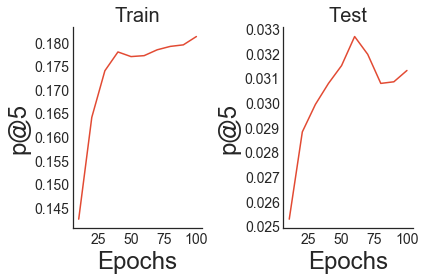

In [20]:
import seaborn as sns
sns.set_style('white')
# ?sns.set_style
def plot_patk(iterarray, patk,
              title, k=5):
    plt.plot(iterarray, patk);
    plt.title(title, fontsize=20);
    plt.xlabel('Epochs', fontsize=24);
    plt.ylabel('p@{}'.format(k), fontsize=24);
    plt.xticks(fontsize=14);
    plt.yticks(fontsize=14);

# Plot train on left
ax = plt.subplot(1, 2, 1)
fig = ax.get_figure();
sns.despine(fig);
plot_patk(iterarray, train_patk,
         'Train', k=5)

# Plot test on right
ax = plt.subplot(1, 2, 2)
fig = ax.get_figure();
sns.despine(fig);
plot_patk(iterarray, test_patk,
         'Test', k=5)

plt.tight_layout();

## Optimizing Hyperparameters with 
`scikit-optimize`

In [24]:
from skopt import forest_minimize
def objective(params):
    # unpack
    epochs, learning_rate,\
    no_components, alpha = params
    
    user_alpha = alpha
    item_alpha = alpha
    model = LightFM(loss='warp',
                    random_state=2016,
                    learning_rate=learning_rate,
                    no_components=no_components,
                    user_alpha=user_alpha,
                    item_alpha=item_alpha)
    model.fit(train, epochs=epochs,
              num_threads=4, verbose=True)
    
    patks = lightfm.evaluation.precision_at_k(model, test,
                                              train_interactions=None,
                                              k=5, num_threads=4)
    mapatk = np.mean(patks)
    # Make negative because we want to _minimize_ objective
    out = -mapatk
    # Handle some weird numerical shit going on
    if np.abs(out + 1) < 0.01 or out < -1.0:
        return 0.0
    else:
        return out

In [25]:
space = [(1, 260), # epochs
         (10**-4, 1.0, 'log-uniform'), # learning_rate
         (20, 200), # no_components
         (10**-6, 10**-1, 'log-uniform'), # alpha
        ]

res_fm = forest_minimize(objective, space, n_calls=250,
                     random_state=0,
                     verbose=True)


Iteration No: 1 started. Evaluating function at random point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100
Epoch 101
Epoch 102
Epoch 103
Epoch 10

Epoch 184
Epoch 185
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 197.8409
Function value obtained: -0.0000
Current minimum: -0.0310
Iteration No: 8 started. Evaluating function at random point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
E

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 35.5367
Function value obtained: -0.0385
Current minimum: -0.0394
Iteration No: 18 started. Searching for the next optimal point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 35.5429
Function value obtained: -0.0001
Current minimum: -0.0394
Iteration No: 19 started. Searching for the next optimal poi

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 54.4427
Function value obtained: -0.0417
Current minimum: -0.0443
Iteration No: 35 started. Searching for the next optimal point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45

Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 71.7917
Function value obtained: -0.0390
Current minimum: -0.0443
Iteration No: 46 started. Searching for the next optimal point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67

Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100
Epoch 101
Epoch 102
Epoch 103
Epoch 104
Epoch 105
Epoch 106
Epoch 107
Epoch 108
Epoch 109
Epoch 110
Epoch 111
Epoch 112
Epoch 113
Epoch 114
Epoch 115
Epoch 116
Epoch 117
Epoch 118
Epoch 119
Epoch 120
Epoch 121
Epoch 

Epoch 111
Epoch 112
Epoch 113
Epoch 114
Epoch 115
Epoch 116
Epoch 117
Epoch 118
Epoch 119
Epoch 120
Epoch 121
Epoch 122
Epoch 123
Epoch 124
Epoch 125
Epoch 126
Epoch 127
Epoch 128
Epoch 129
Epoch 130
Epoch 131
Epoch 132
Epoch 133
Epoch 134
Epoch 135
Epoch 136
Epoch 137
Epoch 138
Epoch 139
Epoch 140
Epoch 141
Epoch 142
Epoch 143
Epoch 144
Epoch 145
Epoch 146
Epoch 147
Epoch 148
Epoch 149
Epoch 150
Epoch 151
Epoch 152
Epoch 153
Epoch 154
Epoch 155
Epoch 156
Epoch 157
Epoch 158
Epoch 159
Epoch 160
Epoch 161
Epoch 162
Epoch 163
Epoch 164
Epoch 165
Epoch 166
Epoch 167
Epoch 168
Epoch 169
Epoch 170
Epoch 171
Epoch 172
Epoch 173
Epoch 174
Epoch 175
Epoch 176
Epoch 177
Epoch 178
Epoch 179
Epoch 180
Epoch 181
Epoch 182
Epoch 183
Epoch 184
Epoch 185
Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 162.5886
Function value obtained: -0.0406
Current minimum: -0.0443
Iteration No: 57 started. Searching for the next optimal point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4

Epoch 201
Epoch 202
Epoch 203
Epoch 204
Epoch 205
Epoch 206
Epoch 207
Epoch 208
Epoch 209
Epoch 210
Epoch 211
Epoch 212
Epoch 213
Epoch 214
Epoch 215
Epoch 216
Epoch 217
Epoch 218
Epoch 219
Epoch 220
Epoch 221
Epoch 222
Epoch 223
Epoch 224
Epoch 225
Epoch 226
Epoch 227
Epoch 228
Epoch 229
Epoch 230
Epoch 231
Epoch 232
Epoch 233
Epoch 234
Epoch 235
Epoch 236
Epoch 237
Epoch 238
Epoch 239
Epoch 240
Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 190.4217
Function value obtained: -0.0437
Current minimum: -0.0451
Iteration No: 60 started. Searching for the next optimal point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epo

Epoch 252
Epoch 253
Epoch 254
Epoch 255
Epoch 256
Epoch 257
Epoch 258
Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 314.5714
Function value obtained: -0.0447
Current minimum: -0.0451
Iteration No: 63 started. Searching for the next optimal point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80


Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100
Epoch 101
Epoch 102
Epoch 103
Epoch 104
Epoch 105
Epoch 106
Epoch 107
Epoch 108
Epoch 109
Epoch 110
Epoch 111
Epoch 112
Epoch 113
Epoch 114
Epoch 115
Epoch 116
Epoch 117
Epoch 118
Epoch 119
Epoch 120
Epoch 121
Epoch 122
Epoch 123
Epoch 124
Epoch 125
Epoch 126
Epoch 127
Epoch 128
Epoch 129
Epoch 130
Epoch 131
Epoch 132
Epoch 133
Epoch 134
Epoch 135
Epoch 136
Epoch 137
Epoch 138
Epoch 139
Epoch 

Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100
Epoch 101
Epoch 102
Epoch 103
Epoch 104
Epoch 105
Epoch 106
Epoch 107
Epoch 108
Epoch 109
Epoch 110
Epoch 111
Epoch 112
Epoch 113
Epoch 114
Epoch 115
Epoch 116
Epoch 117
Epoch 118
Epoch 119
Epoch 120
Epoch 121
Epoch 122
Epoch 123
Epoch 124
Epoch 125
Epoch 126
Epoch 127
Epoch 128
Epoch 129
Epoch 130
Epoch 131
Epoch 132
Epoch 133
Epoch 134
Epoch 135
Epoch 136
Epoch 137
Epoch 138
Epoch 139
Epoch 140
Epoch 141
Epoch 142
Epoch 143
Epoch 144
Epoch 145
Epoch 146
Epoch 147
Epoch 148
Epoch 149
Epoch 150
Epoch 151
Epoch 152
Epoch 153
E

Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100
Epoch 101
Epoch 102
Epoch 103
Epoch 104
Epoch 105
Epoch 106
Epoch 107
Epoch 108
Epoch 109
Epoch 110
Epoch 111
Epoch 112
Epoch 113
Epoch 114
Epoch 115
Epoch 116
Epoch 117
Epoch 118
Epoch 119
Epoch 120
Epoch 121
Epoch 122
Epoch 123
Epoch 124
Epoch 125
Epoch 126
Epoch 127
Epoch 128
Epoch 129
Epoch 130
Epoch 131
Epoch 132
Epoch 133
Epoch 134
Epoch 135
Epoch 136
Epoch 137
Epoch 138
Epoch 139
Epoch 140
Epoch 141
Epoch 142
Epoch 143
Epoch 144
Epoch 145
Epoch 146
Epoch 147
Epoch 148
Epoch 149
Epoch 150
Epoch 151
Epoch 152
Epoch 153
Epoch 154
Epoch 155
Epoch 156
Epoch 157
Epoch 158
Epoch 159
Epoch 160
Epoch 161
Epoch 162
Epoch 163
Epoch 164
Epoch 165
Epoch 166
Epoch 167
Epoch 168
Epoch 169
Epoch 170
Epoch 171
Epoch 172
Epoch 173
Epoch 174
Epoch 175
Epoch 176
Epoch 177
Epoch 178
Epoch 179
Epoch 180
Epoch 181
Epoch 182

Epoch 104
Epoch 105
Epoch 106
Epoch 107
Epoch 108
Epoch 109
Epoch 110
Epoch 111
Epoch 112
Epoch 113
Epoch 114
Epoch 115
Epoch 116
Epoch 117
Epoch 118
Epoch 119
Epoch 120
Epoch 121
Epoch 122
Epoch 123
Epoch 124
Epoch 125
Epoch 126
Epoch 127
Epoch 128
Epoch 129
Epoch 130
Epoch 131
Epoch 132
Epoch 133
Epoch 134
Epoch 135
Epoch 136
Epoch 137
Epoch 138
Epoch 139
Epoch 140
Epoch 141
Epoch 142
Epoch 143
Epoch 144
Epoch 145
Epoch 146
Epoch 147
Epoch 148
Epoch 149
Epoch 150
Epoch 151
Epoch 152
Epoch 153
Epoch 154
Epoch 155
Epoch 156
Epoch 157
Epoch 158
Epoch 159
Epoch 160
Epoch 161
Epoch 162
Epoch 163
Epoch 164
Epoch 165
Epoch 166
Epoch 167
Epoch 168
Epoch 169
Epoch 170
Epoch 171
Epoch 172
Epoch 173
Epoch 174
Epoch 175
Epoch 176
Epoch 177
Epoch 178
Epoch 179
Epoch 180
Epoch 181
Epoch 182
Epoch 183
Epoch 184
Epoch 185
Epoch 186
Epoch 187
Epoch 188
Epoch 189
Epoch 190
Epoch 191
Epoch 192
Epoch 193
Epoch 194
Epoch 195
Epoch 196
Epoch 197
Epoch 198
Epoch 199
Epoch 200
Epoch 201
Epoch 202
Epoch 203


Epoch 142
Epoch 143
Epoch 144
Epoch 145
Epoch 146
Epoch 147
Epoch 148
Epoch 149
Epoch 150
Epoch 151
Epoch 152
Epoch 153
Epoch 154
Epoch 155
Epoch 156
Epoch 157
Epoch 158
Epoch 159
Epoch 160
Epoch 161
Epoch 162
Epoch 163
Epoch 164
Epoch 165
Epoch 166
Epoch 167
Epoch 168
Epoch 169
Epoch 170
Epoch 171
Epoch 172
Epoch 173
Epoch 174
Epoch 175
Epoch 176
Epoch 177
Epoch 178
Epoch 179
Epoch 180
Epoch 181
Epoch 182
Epoch 183
Epoch 184
Epoch 185
Epoch 186
Epoch 187
Epoch 188
Epoch 189
Epoch 190
Epoch 191
Epoch 192
Epoch 193
Epoch 194
Epoch 195
Epoch 196
Epoch 197
Epoch 198
Epoch 199
Epoch 200
Epoch 201
Epoch 202
Epoch 203
Epoch 204
Epoch 205
Epoch 206
Epoch 207
Epoch 208
Epoch 209
Epoch 210
Epoch 211
Epoch 212
Epoch 213
Epoch 214
Epoch 215
Epoch 216
Epoch 217
Epoch 218
Epoch 219
Epoch 220
Epoch 221
Epoch 222
Epoch 223
Epoch 224
Epoch 225
Epoch 226
Epoch 227
Epoch 228
Epoch 229
Epoch 230
Epoch 231
Epoch 232
Epoch 233
Epoch 234
Epoch 235
Epoch 236
Epoch 237
Epoch 238
Epoch 239
Epoch 240
Epoch 241


Epoch 155
Epoch 156
Epoch 157
Epoch 158
Epoch 159
Epoch 160
Epoch 161
Epoch 162
Epoch 163
Epoch 164
Epoch 165
Epoch 166
Epoch 167
Epoch 168
Epoch 169
Epoch 170
Epoch 171
Epoch 172
Epoch 173
Epoch 174
Epoch 175
Epoch 176
Epoch 177
Epoch 178
Epoch 179
Epoch 180
Epoch 181
Epoch 182
Epoch 183
Epoch 184
Epoch 185
Epoch 186
Epoch 187
Epoch 188
Epoch 189
Epoch 190
Epoch 191
Epoch 192
Epoch 193
Epoch 194
Epoch 195
Epoch 196
Epoch 197
Epoch 198
Epoch 199
Epoch 200
Epoch 201
Epoch 202
Epoch 203
Epoch 204
Epoch 205
Epoch 206
Epoch 207
Epoch 208
Epoch 209
Epoch 210
Epoch 211
Epoch 212
Epoch 213
Epoch 214
Epoch 215
Epoch 216
Epoch 217
Epoch 218
Epoch 219
Epoch 220
Epoch 221
Epoch 222
Epoch 223
Epoch 224
Epoch 225
Epoch 226
Epoch 227
Epoch 228
Epoch 229
Epoch 230
Epoch 231
Epoch 232
Epoch 233
Epoch 234
Epoch 235
Epoch 236
Epoch 237
Epoch 238
Epoch 239
Epoch 240
Epoch 241
Epoch 242
Epoch 243
Epoch 244
Epoch 245
Epoch 246
Epoch 247
Epoch 248
Epoch 249
Epoch 250
Epoch 251
Epoch 252
Epoch 253
Epoch 254


Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100
Epoch 101
Epoch 102
Epoch 103
Epoch 104
Epoch 105
Epoch 106
Epoch 107
Epoch 108
Epoch 109
Epoch 110
Epoch 111
Epoch 112
Epoch 113
Epoch 114
Epoch 115
Epoch 116
Epoc

Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100
Epoch 101
Epoch 102
Epoch 103
Epoch 104
Epoch 105
Epoch 106
Epoch 107
Epoch 108
Epoch 109
Epoch 110
Epoch 111
Epoch 112
Epoch 113
Epoch 114
Epoch 115
Epoch 116
Epoch 117
Epoch 118
Epoch 119
Epoch 120
Epoch 121
Epoch 122
Epoch 123
Epoch 124
Epoch 125
Epoch 126
Epoch 127
Epoch 128
Epoch 129
Epoch 130
Epoch 131
Epoch 132
Epoch 133
Epoch 134
Epoch 135
Epoch 136
Epoch 137
Epoch 138
Epoch 139
Epoch 140
Epoch 141
Epoch 142
Epoch 143
Epoch 144
Epoch 145
Epoch 146
Epoch 14

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100
Epoch 101
Epoch 102
Epoch 103
Epoch 104
Epoch 105
Epoch 106
Epoch 107
Epoch 108
Epoch 109
Epoch 110
Epoch 11

KeyboardInterrupt: 

In [26]:
print('Maximimum p@k found: {:6.5f}'.format(-res_fm.fun))
print('Optimal parameters:')
params = ['epochs', 'learning_rate', 'no_components', 'alpha']
for (p, x_) in zip(params, res_fm.x):
    print('{}: {}'.format(p, x_))



NameError: name 'res_fm' is not defined

# Learning to Rank + Side information

In [21]:
eye = sp.eye(item_features.shape[0],item_features.shape[0]).tocsr()
item_features_concat = sp.hstack((eye,item_features))
item_features_concat = item_features_concat.tocsr().astype(np.float32)

In [22]:
from skopt import forest_minimize

In [23]:
def objective_wsideinfo(params):
    # unpack
    epochs, learning_rate,\
    no_components, item_alpha,\
    scale = params
    
    user_alpha = item_alpha * scale
    model = LightFM(loss='warp',
                    random_state=2016,
                    learning_rate=learning_rate,
                    no_components=no_components,
                    user_alpha=user_alpha,
                    item_alpha=item_alpha)
    model.fit(train, epochs=epochs,
              item_features=item_features_concat,
              num_threads=4, verbose=True)
    
    patks = lightfm.evaluation.precision_at_k(model, test,
                                              item_features=item_features_concat,
                                              train_interactions=None,
                                              k=5, num_threads=3)
    mapatk = np.mean(patks)
    # Make negative because we want to _minimize_ objective
    out = -mapatk
    # Weird shit going on
    if np.abs(out + 1) < 0.01 or out < -1.0:
        return 0.0
    else:
        return out